In [102]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [103]:
import shutil

def createIfNotExist(path):
    isExist = os.path.exists(path)
    if not isExist:
      os.makedirs(path)
      print(f"The new directory {path} is created!")

In [104]:
from PIL import Image
import os

FORMAT = 'jpeg'
# FORMAT = 'jpg'

def preprocess_image(input_path, output_path, shape=512, pref=''):
    output_name = pref
    paths_to_images = []
    image = Image.open(input_path)
    image = image.resize((shape, shape))
    output_path = output_path.split('.')[0] + '.jpg'
    image.save(output_path)
    paths_to_images.append(output_path + output_name + "." + FORMAT)
    return paths_to_images


def preprocess_all_images_int_file_tree(input_path, output_path):
    cnt = 0
    for root, dirs, files in os.walk(input_path):
        for dir_name in dirs:
            if not os.path.exists(os.path.join(output_path, dir_name)):
                os.mkdir(os.path.join(output_path, dir_name))
        for file in os.listdir(root):
            if os.path.join(root, file).split('.')[-1] != FORMAT:
                cnt += 1
                continue
            cnt += 1
    with tqdm(total=cnt) as pbar:
        for root, dirs, files in os.walk(input_path):
            for file in os.listdir(root):
                if os.path.join(root, file).split('.')[-1] != FORMAT:
                    pbar.update(1)
                    continue
                curr_out_path = os.path.join(os.path.join(output_path + root.split('/')[-1]),file)
                preprocess_image(os.path.join(root, file), curr_out_path)
                pbar.update(1)

input_dataset_path = "raw_data/"
reduced_output_dataset_path = "reduced_data/"

createIfNotExist(reduced_output_dataset_path)

preprocess_all_images_int_file_tree(input_dataset_path, reduced_output_dataset_path)

The new directory reduced_data/ is created!


100%|██████████| 333/333 [00:11<00:00, 29.93it/s]


In [105]:
folders = [name for name in os.listdir(reduced_output_dataset_path) if os.path.isdir(os.path.join(os.getcwd(), reduced_output_dataset_path, name))]
folders, len(folders)

(['Morport',
  'Delta',
  'Most',
  'Looskii',
  'Teatr',
  'Sobor',
  'Bogatyr',
  'Fisht',
  'Omega',
  'Shaiba',
  'Fakel'],
 11)

In [108]:
train_prob = 0.3333333
test_prob = 0.3333333
val_prob = 0.3333333
random_state = 228
np.random.seed(random_state)

train = []
test = []
val = []
all_data = []

for folder in folders:
    files = os.listdir(os.path.join(os.getcwd(), reduced_output_dataset_path, folder))
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    np.random.shuffle(files)
    train_ind = int(len(files) * train_prob)
    test_ind = int(len(files) * (train_prob + test_prob))
    train.append((files[:train_ind + 1], folder))
    test.append((files[train_ind + 1:test_ind + 1], folder))
    val.append((files[test_ind + 1:], folder))
    all_data.append((files, folder))

In [109]:
result_folder = "airi_dataset"

In [110]:
def process_subset(files, subset_name):
    for files_arr, folder in files:
        curDir = os.path.join(os.getcwd(), result_folder, subset_name, folder)
        createIfNotExist(curDir)
        for file in files_arr:
            srcFile = os.path.join(os.getcwd(), reduced_output_dataset_path, folder, file)
            print(srcFile)
            dstFile = os.path.join(os.getcwd(), result_folder, subset_name, folder, file)
            shutil.copyfile(srcFile, dstFile)

In [111]:
createIfNotExist(result_folder)

process_subset(train, 'train')
process_subset(test, 'test')
process_subset(val, 'val')

The new directory airi_dataset is created!
The new directory /Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/airi_dataset/train/Morport is created!
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_24.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_27.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_22.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_15.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_6.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_5.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport/Morport_18.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Morport

In [112]:
class_count = [len(samples) for (samples, class_name) in all_data]
classes = [class_name for (samples, class_name) in all_data]
class_count

[30, 12, 30, 30, 30, 30, 30, 30, 30, 30, 30]

In [113]:
import json

metainfo = {'num_to_class': {i:name for i, name in enumerate(folders)},
            'data': {'train_size': sum([len(x[0]) for x in train]),
                    'test_size': sum([len(x[0]) for x in test]),
                    'val_size': sum([len(x[0]) for x in val]),
                    'class_count': class_count
                    }
            }

with open(f"{result_folder}/metainfo.json", "w") as fout:
    json.dump(metainfo, fout)

In [100]:
len(class_count)

21

Text(0.5, 1.0, 'Classes distribution')

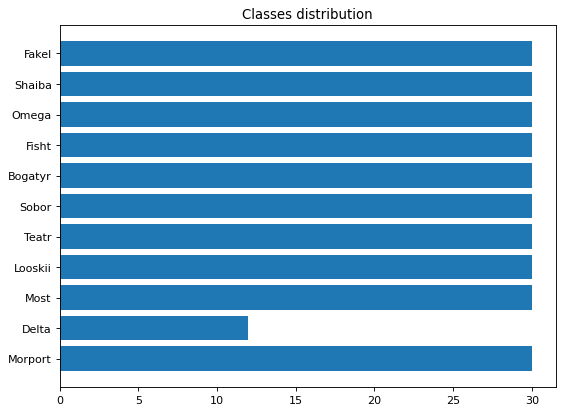

In [114]:
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(classes, width=class_count)
plt.title('Classes distribution')